# Housing Values Prediction

The task of this excercise is to predict the median housing values for California's districts, given the number of features form these disctricts. This dataset is based on the data from 1990 California census.

Its a Supervised learning task, since we are given the labeled trainign data. <br>
Its a regression task, since we are asked to predict a value.<br>
Its a univariate regression problem, since we are trying to predict only one value i.e. Median housing value.<br>
Its a batcg learning ML system, since its not a continous flow of data and we don't have to adjust the changing data rapidly. <br>

In This excercise we will:

-   Read and Load the data
-   Try to understand the data
-   Play with data and create some new data attributes or convert categorical attributes
-   Split the data into training and testing data sets
-   Handle missing values
-   Perform scaling of data attributes, so they fall under same scale of values to prevent biased results
-   Use pipelines to perform a seies of operations on data sets
-   Train various models and evaluate their performance
-   Evaluate our model's performance using Root Mean Squred Error and Cross Validation
-   Will do Hyperparameter tuning using GridSearchCV
-   Based on best estimators from GridSearchCV we will perform predictions on testing data sets

In [104]:
#We need to check correct versions of Python and skLearn. Also import all the common packages at this point.
# python >= 3.5
import sys
assert sys.version_info >= (3, 5)

# sklearn >= 0.20 
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [105]:
# Now we will load the data which is in a CSV to a dataframe
def load_data():
    csv_path = "https://raw.githubusercontent.com/ash10don/ML_Projects/main/datasets/housing.csv" 
    return pd.read_csv(csv_path)

In [61]:
housing = load_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 3. Try to understand the data

In [62]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [63]:
# Ocean proximity looks like a categorical attribute, lets check how many categories exists
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [64]:
# Now lets see the summary of numeric attributes using describe()
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


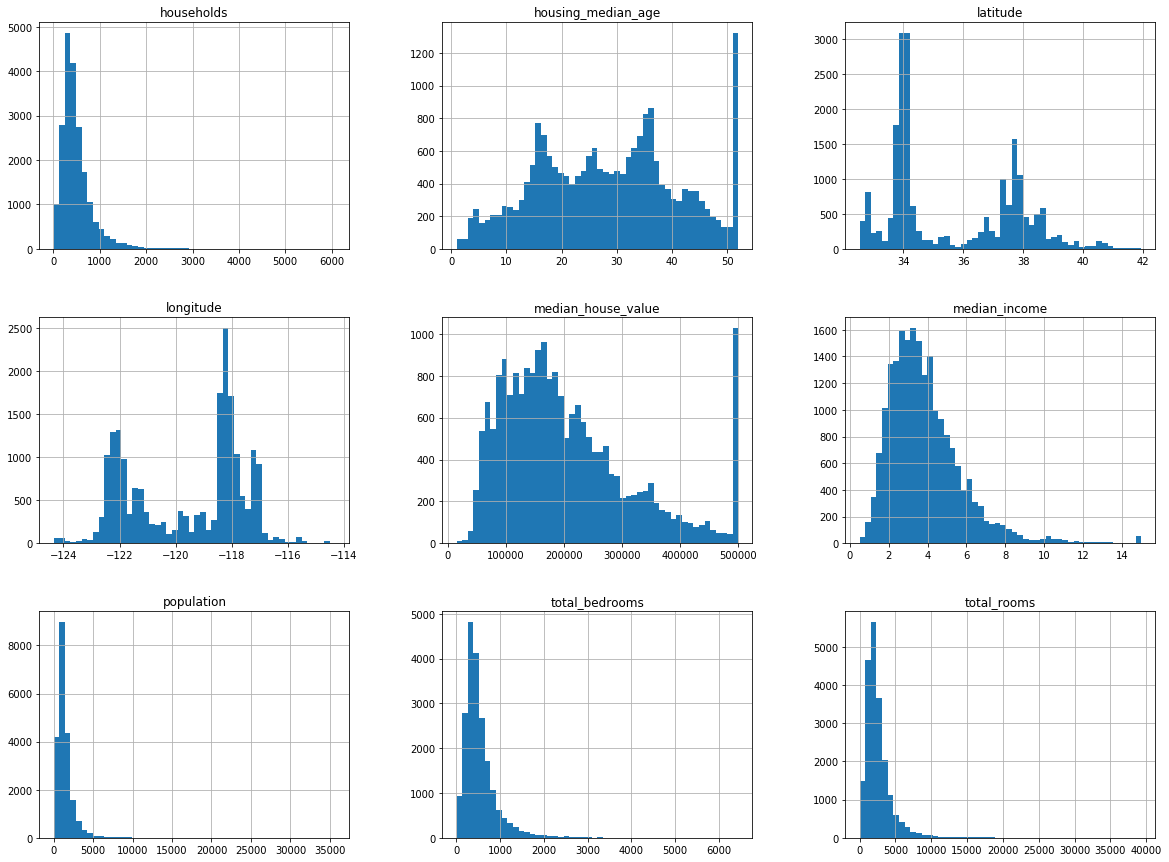

In [65]:
# Lets look at the histogram

housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [66]:
# It looks like median_income is a very important attribute in predicting housing values. Hence before spliting data 
# into train and test sets, we will create a income_cat attribute based on median_income and then will spilt data. 
# The reason we are doing this is because if we just spilt data without considering different income groups it will 
# be a random sample which may be biased.
# Hence we will create sets based on stratified sampling because we need to include all income categories in data
# Median income is a continous numeric attribute, so we have to create a new categorical attribute based on it. 
# This will help us split the data in train and test data sets based on income categories. Which will not be a random sampling.

housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1,2,3,4,5])

In [67]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

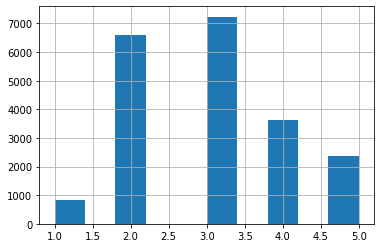

In [68]:
housing["income_cat"].hist()

In [69]:
# Now we are ready to do stratified sampling based on income category, for which we will use sklearn's StratifiedShuffleSpilt Class.

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    housing_train_set = housing.loc[train_index]
    housing_test_set = housing.loc[test_index]

In [70]:
# Lets check income category proportions in test set as compared to complete set

housing_test_set["income_cat"].value_counts() / len(housing_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [71]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [72]:
# Remove income category attribute now

for set_ in (housing_train_set, housing_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [73]:
# Lets create a copy to play with data without harming the actual training data

housing = housing_train_set.copy()

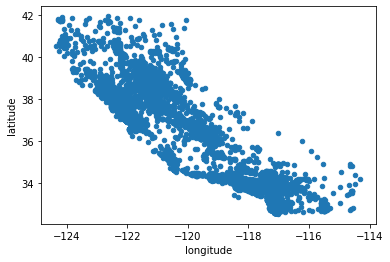

In [74]:
# Lets do a scatter plot of longitude and latitude

housing.plot(kind="scatter", x="longitude", y="latitude")

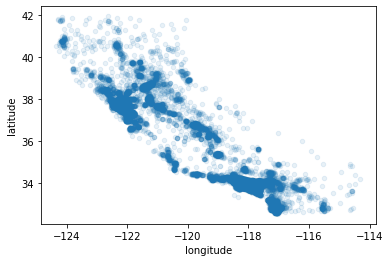

In [75]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

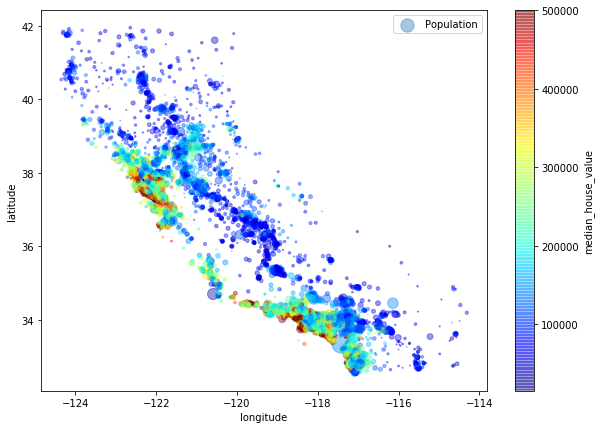

In [21]:
# Lets look at the housing prices

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
            s=housing["population"]/100, label="Population", figsize=(10,7), 
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
plt.legend()

In [76]:
# Lets compute standard correlation coefficient (Pearson's r)

corr_matrix = housing.corr()

In [77]:
# See how much each attribute is correlated to median_house_value

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

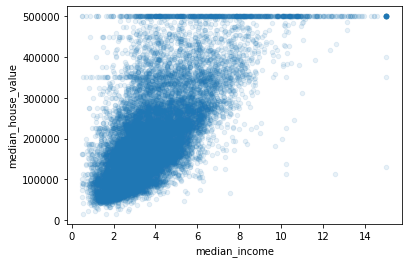

In [78]:
# Most promising attribute for predicting median_house_value seems to be median_income, so lets zoom in on its scatter plot

housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [79]:
# Lets try out some attribute combinations

housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [80]:
# Preparing data for Machine Learning
# Lets revert to the clean training set and seperate predictors and labels

housing = housing_train_set.drop("median_house_value", axis=1)
housing_labels = housing_train_set["median_house_value"].copy()

In [82]:
# We will be using pipeline for a sequence of tasks we will perform on data to get is ready

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Getting only the mumeric attributes
housing_num = housing.drop("ocean_proximity", axis=1)

# pipeline to transform numeric attributes
# We have used SimpleImputer to replace missing values with median values
# And StandardScaler to scale the attributes so that theu fell in same scales
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])


num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# Using ColumnTransformer we are concatenating the results of both numeric pipeline and categorical attribute operations.
# OneHotEncoder is used to generate a sparse matrix of numeric values from a categorical attribute which is ocean_proximity.
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [83]:
# Select and train models

# Linear regression
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [84]:
# Lets calculate the error

from sklearn.metrics import mean_squared_error

house_predict = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, house_predict)
lin_rmse = np.sqrt(lin_mse)
print("RMSE:", lin_rmse)

from sklearn.metrics import mean_absolute_error
lin_mae = mean_absolute_error(housing_labels, house_predict)
print("MAE:",lin_mae)

RMSE: 69050.98178244587
MAE: 49906.94142223289


In [85]:
# Now lets try it on another model (DecisionTreeRegressor)

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [86]:
# Lets calculate the error

house_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, house_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [88]:
# Better evaluation of DecisionTreeRegressor using Cross-validation
# on 10 folds

from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

print("Scores:", tree_rmse_scores)
print("Mean:", tree_rmse_scores.mean())
print("Standard deviation:", tree_rmse_scores.std())

Scores: [66757.2013883  66708.05413959 71135.77592971 69317.58307062
 68729.37098167 75649.34082791 67043.83260349 70251.84122452
 69273.49135944 69161.37598811]
Mean: 69402.78675133755
Standard deviation: 2512.0648514114073


In [89]:
# Better evaluation of LinearRegression using Cross-validation
# on 10 folds

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

print("Scores:", lin_rmse_scores)
print("Mean:", lin_rmse_scores.mean())
print("Standard deviation:", lin_rmse_scores.std())

Scores: [67450.42057782 67329.50264436 68361.84864912 74639.88837894
 68314.56738182 71628.61410355 65361.14176205 68571.62738037
 72476.18028894 68098.06828865]
Mean: 69223.18594556303
Standard deviation: 2657.2683112777


In [90]:
# Now lets try it on another model (RandomForestRegressor)
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [91]:
# Lets calculate the error

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18381.60959473712

In [92]:
# Better evaluation of RandomForestRegressor using Cross-validation
# on 10 folds

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

print("Scores:", forest_rmse_scores)
print("Mean:", forest_rmse_scores.mean())
print("Standard deviation:", forest_rmse_scores.std())

Scores: [48029.48533981 46180.5842788  49223.75819862 50128.49951756
 49245.88299731 53012.54776749 48929.83322119 50553.69113261
 51238.86812275 49550.65072314]
Mean: 49609.38012992901
Standard deviation: 1743.4668169136653


In [93]:
# Now lets try it on another model (Support vector machine) and its error

from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111803.81648688269

In [94]:
# Among all the above models we tried RandomForestRegressor seemed more promising
# Lets fine tune the hyperparameters for RandomForestRegressor using GridSearchCV

from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],
  

In [98]:
# So the best params are:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [99]:
# Best estimator are:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [100]:
# Lets see all the scores against the params
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

65005.23544117202 {'max_features': 2, 'n_estimators': 3}
55582.91095287357 {'max_features': 2, 'n_estimators': 10}
52745.26618728503 {'max_features': 2, 'n_estimators': 30}
60451.03587113582 {'max_features': 4, 'n_estimators': 3}
53062.670647263374 {'max_features': 4, 'n_estimators': 10}
50663.670121065385 {'max_features': 4, 'n_estimators': 30}
57997.86051393278 {'max_features': 6, 'n_estimators': 3}
52041.89470150572 {'max_features': 6, 'n_estimators': 10}
50027.95847993363 {'max_features': 6, 'n_estimators': 30}
58308.32072258077 {'max_features': 8, 'n_estimators': 3}
52082.57922009913 {'max_features': 8, 'n_estimators': 10}
50165.699617315484 {'max_features': 8, 'n_estimators': 30}
62709.37986469409 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54061.872909982965 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60613.43089865496 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53742.869337730976 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [101]:
# We can also get importance of every attribute we have, which will help us in making accurate predictions
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.23217663e-01, 1.11356292e-01, 4.78286833e-02, 3.52467654e-02,
       2.93564433e-02, 4.53191983e-02, 2.83807377e-02, 4.07868459e-01,
       2.00598018e-02, 1.36345702e-01, 5.79834167e-05, 6.93251602e-03,
       8.02975484e-03])

In [102]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.40786845907794983, 'median_income'),
 (0.1363457019194639, 'pop_per_hhold'),
 (0.12321766261652732, 'longitude'),
 (0.11135629230575723, 'latitude'),
 (0.04782868332880397, 'housing_median_age'),
 (0.045319198270076334, 'population'),
 (0.035246765429525415, 'total_rooms'),
 (0.029356443266387613, 'total_bedrooms'),
 (0.02838073769027157, 'households'),
 (0.02005980181428337, 'rooms_per_hhold'),
 (0.008029754844640458, 'INLAND'),
 (0.006932516019638101, '<1H OCEAN'),
 (5.798341667501236e-05, 'bedrooms_per_room')]

In [106]:
# Finally predicting the values of test data set
# And calculating its error

final_model = grid_search.best_estimator_

X_test = housing_test_set.drop("median_house_value", axis=1)
y_test = housing_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

print("Predictions:", final_predictions[:5])
print("Labels:", list(y_test[:5]))

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

Predictions: [478684.         240053.36666667 217866.66666667 236933.33333333
 134260.        ]
Labels: [500001.0, 240300.0, 218200.0, 182100.0, 121300.0]


47362.98158022501